In [1]:
#mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
# memastikan bahwa notebook ini menggunakan versi terbaru dari TensorFlow
%tensorflow_version 2.x

# Gunakan tensorflow versi 2
import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.17.1


In [4]:
# Instal libray transformer
!pip -q install transformers

In [5]:
# mencetak versi library transformers yang digunakan pada notebook ini
import transformers
print(transformers.__version__)

4.46.3


In [6]:
data = pd.read_excel('/content/drive/MyDrive/Portfolio/Sentiment Analysis User Reviews App GetContact/LabellingData GetContact/GetContact_DataTrainIdnLabeledBalanced.xlsx')
data.head()

,content_normalisasi2,Label
0,premium jadi gratis,Positif
1,Cuma premiumin gada huangg pro ishhh pdhl udah...,Positif
2,aplikasi yang sesuai,Positif
3,berguna,Positif
4,sangat bagus,Positif


In [7]:
# mengubah data dari string menjadi integer
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()

data['Label'] = lb.fit_transform(data['Label'])
data


,content_normalisasi2,Label
0,premium jadi gratis,1
1,Cuma premiumin gada huangg pro ishhh pdhl udah...,1
2,aplikasi yang sesuai,1
3,berguna,1
4,sangat bagus,1
...,...,...
1195,dibayar tidak,0
1196,"Hadeh, buka, orang sudah bayar",0
1197,memaksa,0
1198,"Tidak terlihat tagnya, gratis, premium mahal, ...",0


In [8]:
# Copy data
raw_data = data.copy()

In [9]:
import re

def text_preprocessing(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()                               # Menghapus whitespaces
  return text


In [10]:
# mengaplikasikan fungsi text_preprocessing pada setiap baris teks dalam kolom Text pada data yang diberikan.
%time data['content_normalisasi2'] = data['content_normalisasi2'].apply(text_preprocessing)

CPU times: user 7.07 ms, sys: 0 ns, total: 7.07 ms
Wall time: 7.02 ms


In [11]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(data, test_size=0.3)
df_val, df_test = train_test_split(df_test, test_size=0.5)

df_train.shape, df_test.shape, df_val.shape

((840, 2), (180, 2), (180, 2))

In [12]:
# Mentukan pre-trained model yang akan digunakan untuk fine-tuning

PRE_TRAINED_MODEL = 'indobenchmark/indobert-base-p2'

In [13]:
from transformers import BertTokenizer
bert_tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [14]:
# Lihat vocabulary dari pre-trained model yang telah di load sebelumnya
vocabulary = bert_tokenizer.get_vocab()

print('Panjang vocabulary:', len(vocabulary))
print(vocabulary)

Panjang vocabulary: 30521
{'[PAD]': 0, '[UNK]': 1, '[CLS]': 2, '[SEP]': 3, '[MASK]': 4, '##an': 5, 'd': 6, '##er': 7, 'm': 8, '##en': 9, 's': 10, 'p': 11, '##ar': 12, 'b': 13, 'k': 14, '##at': 15, '##ang': 16, '##in': 17, 't': 18, '##ak': 19, '##al': 20, '##ah': 21, '##as': 22, '##un': 23, '##am': 24, '##em': 25, 'di': 26, '##ya': 27, '##el': 28, '##ad': 29, '##eng': 30, 'y': 31, '##kan': 32, '##tu': 33, 'yang': 34, 'se': 35, '##ap': 36, '##is': 37, 'l': 38, '##ik': 39, 'h': 40, 'dan': 41, 'j': 42, 'ke': 43, '##il': 44, 'men': 45, '##on': 46, '##it': 47, 'in': 48, 'ber': 49, '##us': 50, '##ga': 51, '##or': 52, '##es': 53, 'ter': 54, '##ing': 55, 'r': 56, '##nya': 57, '##ur': 58, '##akan': 59, 'mem': 60, 'c': 61, 'per': 62, '##ut': 63, '##id': 64, '##ari': 65, '##ul': 66, '##um': 67, 'n': 68, '##ada': 69, '##uk': 70, '##ek': 71, '##ir': 72, '##ol': 73, '##ih': 74, '##engan': 75, '##ung': 76, '##eb': 77, 'un': 78, 'dengan': 79, 'meng': 80, '##tuk': 81, '##ag': 82, 'g': 83, '##et': 84, '#

In [15]:
# Contoh Tokenisasi

id_data = 0 # Mengambil data indeks ke-5 pada dataframe

print('Kalimat:', raw_data.content_normalisasi2[id_data])
print('BERT Tokenizer:', bert_tokenizer.tokenize(data.content_normalisasi2[id_data]))

Kalimat: premium jadi gratis
BERT Tokenizer: ['premium', 'jadi', 'gratis']


In [16]:
# input formatting untuk BERT. Input formating dapat menggunakan fungsi `encode_plus`

bert_input = bert_tokenizer.encode_plus(
    data.content_normalisasi2[id_data],             # Sample kalimat
    add_special_tokens = True,      # Tambahkan token [CLS] pada awal kalimat dan token [SEP] pada akhir kalimat
    padding = 'max_length',         # Tambahkan padding ke max_length menggunakan token [PAD] jika kalimat kurang dari max_length
    truncation = 'longest_first',   # Truncate jika kalimat lebih dari max_length
    max_length = 50,                # Tentukan max_length dari seluruh kalimat
    return_attention_mask = True,   # Mengembalikan nilai attention mask
    return_token_type_ids =True     # Mengembalikan nilai token type id (segment embedding)
    )

# Fungsi `encode_plus` mengembalikan 3 nilai: input_ids, token_type_ids, attention_mask
bert_input.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [17]:
# menampilkan informasi yang berbeda mengenai data teks yang diolah dengan model BERT yang sudah di-format dan di-tokenisasi
print('Kalimat\t\t:', raw_data.content_normalisasi2[id_data])                                           # Data asli
print('Tokenizer\t:', bert_tokenizer.convert_ids_to_tokens(bert_input['input_ids']))    # Hasil input formatting + tokenizer
print('Input IDs\t:', bert_input['input_ids'])                                          # Input IDs : indeks token pada vocabulary tokenizer
print('Token Type IDs\t:', bert_input['token_type_ids'])                                # Token type IDs : menunjukkan urutan kalimat pada sequence (segment embedding)
print('Attention Mask\t:', bert_input['attention_mask'])

Kalimat		: premium jadi gratis
Tokenizer	: ['[CLS]', 'premium', 'jadi', 'gratis', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Input IDs	: [2, 5882, 472, 1243, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Token Type IDs	: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention Mask	: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

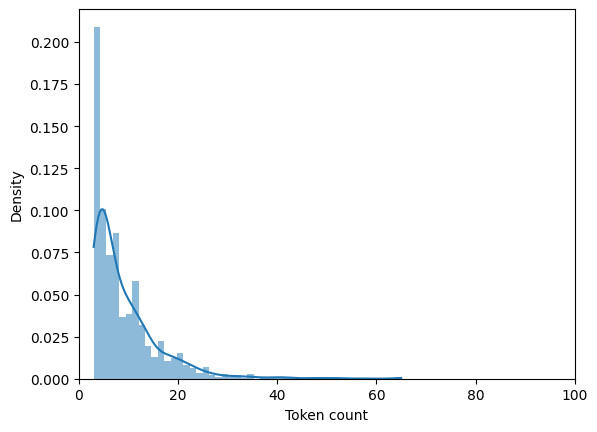

In [18]:
token_lens = []

for txt in data.content_normalisasi2:
  tokens = bert_tokenizer.encode(txt)
  token_lens.append(len(tokens))

sns.histplot(token_lens, kde=True, stat='density', linewidth=0)
plt.xlim([0, 100]);
plt.xlabel('Token count');

In [19]:
# Dapat dilihat dari grafik diatas, sebagian besar kalimat tampaknya berisi kurang dari 60 token
# Maka, tentukan max_length adalah 60

MAX_LEN = 60

In [20]:
# Buat fungsi untuk menggabungkan langkah tokenisasi, menambahkan special tokens untuk keseluruhan data sebagai input formatting ke model BERT
def convert_example_to_feature(sentence):
  return bert_tokenizer.encode_plus(
      sentence,
      add_special_tokens = True,
      padding = 'max_length',
      truncation = 'longest_first',
      max_length = MAX_LEN,
      return_attention_mask = True,
      return_token_type_ids=True
    )

In [21]:
# Membuat fungsi untuk memetakan input hasil input formatting agar sesuai dengan model BERT
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,               # Sebagai token embedding
      "token_type_ids": token_type_ids,     # Sebagai segment embedding
      "attention_mask": attention_masks,    # Sebagai filter informasi mana yang kalkulasi oleh model
  }, label

In [22]:
def encode(data):
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []

  for row in data.itertuples(index=False):
    sentence = row.content_normalisasi2
    label = row.Label
    bert_input = convert_example_to_feature(sentence)

    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [23]:
# Menentukan nilai hyperparamter untuk fine-tuning
EPOCHS = 30
BATCH_SIZE = 16
LEARNING_RATE = 2e-5

In [24]:
# Melakukan input formatting menggunakan fungsi sebelumnya pada data keseluruhan data
train_encoded = encode(df_train).batch(BATCH_SIZE)
test_encoded = encode(df_test).batch(BATCH_SIZE)
val_encoded = encode(df_val).batch(BATCH_SIZE)

In [25]:
from transformers import TFBertForSequenceClassification

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=3)

tf_model.h5:   0%|          | 0.00/656M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# Menentukan optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile model
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [27]:
%%time
bert_history = bert_model.fit(train_encoded, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_encoded)

Epoch 1/30
53/53 [==============================] - 66s 275ms/step - loss: 0.5826 - accuracy: 0.7000 - val_loss: 0.4305 - val_accuracy: 0.8111
Epoch 2/30
53/53 [==============================] - 11s 209ms/step - loss: 0.2970 - accuracy: 0.8845 - val_loss: 0.3880 - val_accuracy: 0.8500
Epoch 3/30
53/53 [==============================] - 12s 231ms/step - loss: 0.1379 - accuracy: 0.9500 - val_loss: 0.6417 - val_accuracy: 0.8278
Epoch 4/30
53/53 [==============================] - 12s 220ms/step - loss: 0.0635 - accuracy: 0.9774 - val_loss: 0.5808 - val_accuracy: 0.8556
Epoch 5/30
53/53 [==============================] - 11s 214ms/step - loss: 0.0560 - accuracy: 0.9810 - val_loss: 0.5359 - val_accuracy: 0.8889
Epoch 6/30
53/53 [==============================] - 12s 228ms/step - loss: 0.0267 - accuracy: 0.9893 - val_loss: 0.6923 - val_accuracy: 0.8444
Epoch 7/30
53/53 [==============================] - 12s 222ms/step - loss: 0.0145 - accuracy: 0.9952 - val_loss: 0.6882 - val_accuracy: 0.8556

In [28]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

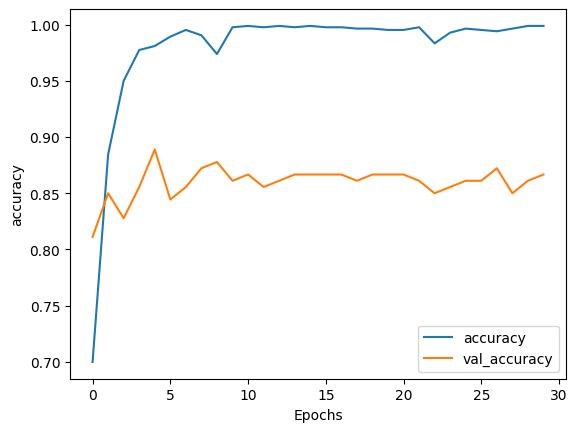

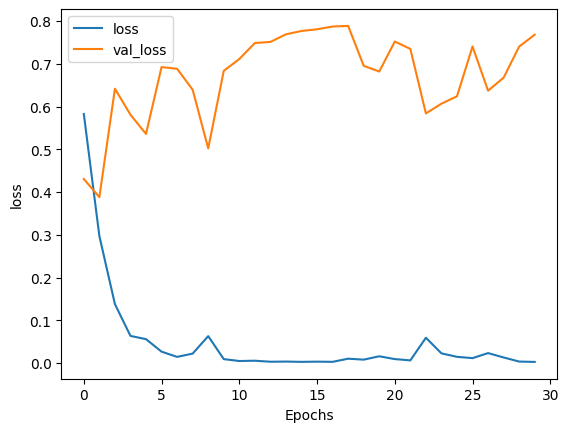

In [29]:
# menghasilkan plot grafik dari performa model BERT selama proses pelatihan dan validasi
plot_graphs(bert_history, 'accuracy')
plot_graphs(bert_history, 'loss')

In [30]:
# mencetak informasi tentang performa model BERT pada setiap epoch selama proses pelatihan (training) dan validasi
print('\nEpoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss')
for i in range(EPOCHS):
  print('{:8d} {:10f} \t {:10f} \t {:10f} \t {:10f}'.format(i + 1, bert_history.history['accuracy'][i], bert_history.history['loss'][i], bert_history.history['val_accuracy'][i], bert_history.history['val_loss'][i]))


Epoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss
       1   0.700000 	   0.582551 	   0.811111 	   0.430511
       2   0.884524 	   0.297015 	   0.850000 	   0.388013
       3   0.950000 	   0.137903 	   0.827778 	   0.641667
       4   0.977381 	   0.063532 	   0.855556 	   0.580845
       5   0.980952 	   0.055981 	   0.888889 	   0.535938
       6   0.989286 	   0.026680 	   0.844444 	   0.692302
       7   0.995238 	   0.014525 	   0.855556 	   0.688247
       8   0.990476 	   0.022193 	   0.872222 	   0.639272
       9   0.973810 	   0.063052 	   0.877778 	   0.502087
      10   0.997619 	   0.009286 	   0.861111 	   0.683442
      11   0.998810 	   0.004845 	   0.866667 	   0.711090
      12   0.997619 	   0.005523 	   0.855556 	   0.748532
      13   0.998810 	   0.003170 	   0.861111 	   0.751098
      14   0.997619 	   0.003538 	   0.866667 	   0.768902
      15   0.998810 	   0.002888 	   0.866667 	   0.776732
      16   0.997619 	   0.003354 	   0.866667 

In [31]:
# menyimpan model
bert_model.save_weights('/content/drive/MyDrive/Portfolio/Sentiment Analysis User Reviews App GetContact/GetContact3016.h5')

In [32]:
# mengevaluasi performa model BERT pada data uji yang telah diubah menjadi bentuk yang dapat diproses oleh model

score = bert_model.evaluate(test_encoded)

print("Test Accuracy:", score[1])

12/12 [==============================] - 1s 72ms/step - loss: 0.4916 - accuracy: 0.8889
Test Accuracy: 0.8888888955116272


In [33]:
# melakukan prediksi menggunakan model BERT pada data uji yang telah diubah menjadi bentuk yang dapat diproses oleh model
predicted_raw = bert_model.predict(test_encoded)

12/12 [==============================] - 3s 72ms/step


In [34]:
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['Label'])

In [35]:

# menghitung akurasi dari model BERT pada data uji dengan membandingkan label kelas yang sebenarnya dengan label kelas yang diprediksi oleh model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

accuracy_score(y_true, y_pred)

0.8888888888888888

In [36]:
# menghasilkan matriks confusion dari model BERT pada data uji.
confusion_matrix(y_true, y_pred)

array([[70, 12],
       [ 8, 90]])

In [37]:
# menghasilkan laporan klasifikasi dari model BERT pada data uji.
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88        82
           1       0.88      0.92      0.90        98

    accuracy                           0.89       180
   macro avg       0.89      0.89      0.89       180
weighted avg       0.89      0.89      0.89       180



In [38]:
sentiment_labels = lb.inverse_transform(data['Label'])
data['Label'] = sentiment_labels

In [39]:
import seaborn as sns
from wordcloud import WordCloud

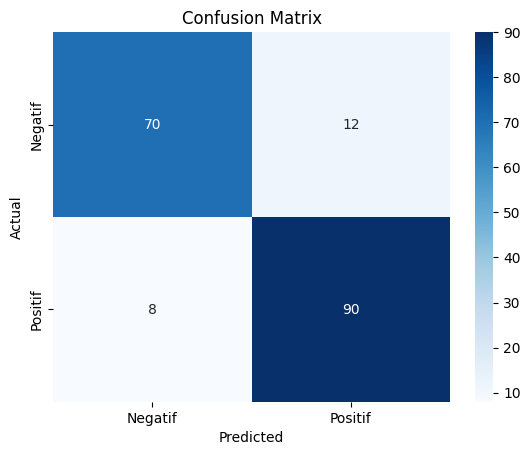

In [40]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=lb.classes_, yticklabels=lb.classes_)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [41]:
data

,content_normalisasi2,Label
0,premium jadi gratis,Positif
1,cuma premiumin gada huangg pro ishhh pdhl udah...,Positif
2,aplikasi yang sesuai,Positif
3,berguna,Positif
4,sangat bagus,Positif
...,...,...
1195,dibayar tidak,Negatif
1196,hadeh buka orang sudah bayar,Negatif
1197,memaksa,Negatif
1198,tidak terlihat tagnya gratis premium mahal sya...,Negatif


In [42]:
data_unlabel = pd.read_excel('/content/drive/MyDrive/Portfolio/Sentiment Analysis User Reviews App GetContact/LabellingData GetContact/GetContact_DataTestIndo.xlsx')
data_unlabel.head()

,content_normalisasi2
0,dibayar
1,"Aplikasi membantu mengenal nomor, silakan guna..."
2,semua aplikasi kikir premium
3,Saya tidak dapat melihat tag gratisnya
4,"terima kasih memudahkan cheatnya, lihat tagnya..."


In [43]:
# Pra-pemrosesan data yang belum diberi label
data_unlabel['content_normalisasi2'] = data_unlabel['content_normalisasi2'].apply(text_preprocessing)

In [44]:
# Ubah data menjadi bentuk yang dapat diproses oleh model BERT
unlabeled_encoded = bert_tokenizer.batch_encode_plus(
    data_unlabel['content_normalisasi2'].tolist(),
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=True
)

In [45]:
def map_example_to_dict_unlabeled(input_ids, attention_masks, token_type_ids):
    return {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_masks,
    }

In [46]:
# Bentuk dataset dari data yang belum diberi label
unlabeled_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': unlabeled_encoded['input_ids'],
        'attention_mask': unlabeled_encoded['attention_mask'],
        'token_type_ids': unlabeled_encoded['token_type_ids']
    },
    tf.zeros((len(data_unlabel),), dtype=tf.int32)  # Labels palsu, semua dengan nilai 0
)).batch(BATCH_SIZE)


In [47]:
# Lakukan prediksi menggunakan model BERT pada data yang belum diberi label
predictions = bert_model.predict(unlabeled_dataset)

137/137 [==============================] - 15s 75ms/step


In [48]:
# Ambil label dengan nilai tertinggi pada setiap prediksi
predicted_labels = tf.argmax(predictions.logits, axis=1).numpy()

In [49]:
# Tambahkan kolom 'Label' pada data yang belum diberi label
data_unlabel['Label'] = predicted_labels

In [50]:
data_unlabel

,content_normalisasi2,Label
0,dibayar,0
1,aplikasi membantu mengenal nomor silakan gunak...,1
2,semua aplikasi kikir premium,0
3,saya tidak dapat melihat tag gratisnya,1
4,terima kasih memudahkan cheatnya lihat tagnya ...,1
...,...,...
2187,saya sudah mencoba login lengkap dengan mengis...,1
2188,masih bagus tapi preminya kalau tidak ada bung...,1
2189,beri saja saya bintang untuk melihat hasilnya,1
2190,kamu pelit hanya melihat tag premium orang,0


In [51]:
data

,content_normalisasi2,Label
0,premium jadi gratis,Positif
1,cuma premiumin gada huangg pro ishhh pdhl udah...,Positif
2,aplikasi yang sesuai,Positif
3,berguna,Positif
4,sangat bagus,Positif
...,...,...
1195,dibayar tidak,Negatif
1196,hadeh buka orang sudah bayar,Negatif
1197,memaksa,Negatif
1198,tidak terlihat tagnya gratis premium mahal sya...,Negatif


In [52]:
sentiment_labels = lb.inverse_transform(data_unlabel['Label'])
data_unlabel['Label'] = sentiment_labels

In [53]:
data_unlabel

,content_normalisasi2,Label
0,dibayar,Negatif
1,aplikasi membantu mengenal nomor silakan gunak...,Positif
2,semua aplikasi kikir premium,Negatif
3,saya tidak dapat melihat tag gratisnya,Positif
4,terima kasih memudahkan cheatnya lihat tagnya ...,Positif
...,...,...
2187,saya sudah mencoba login lengkap dengan mengis...,Positif
2188,masih bagus tapi preminya kalau tidak ada bung...,Positif
2189,beri saja saya bintang untuk melihat hasilnya,Positif
2190,kamu pelit hanya melihat tag premium orang,Negatif


In [54]:
# Menggabungkan data train dan data test yang sudah diberi label oleh model
data_combined = pd.concat([data, data_unlabel], axis=0)

In [55]:
data_combined

,content_normalisasi2,Label
0,premium jadi gratis,Positif
1,cuma premiumin gada huangg pro ishhh pdhl udah...,Positif
2,aplikasi yang sesuai,Positif
3,berguna,Positif
4,sangat bagus,Positif
...,...,...
2187,saya sudah mencoba login lengkap dengan mengis...,Positif
2188,masih bagus tapi preminya kalau tidak ada bung...,Positif
2189,beri saja saya bintang untuk melihat hasilnya,Positif
2190,kamu pelit hanya melihat tag premium orang,Negatif


In [56]:
def map_label_to_sentiment(label):
    if label == 'Negatif':
        return 'Negatif'
    else:
        return 'Positif'

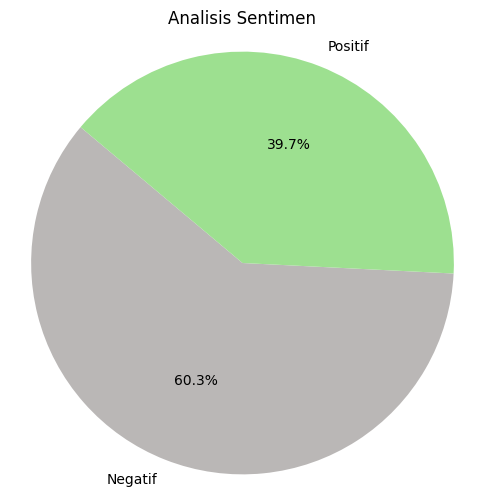

Negatif: 2046 data
Positif: 1346 data


In [57]:
import matplotlib.pyplot as plt

# Menghitung jumlah data untuk masing-masing sentimen
sentiment_counts = data_combined['Label'].value_counts()

# Membuat diagram pie
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#bab7b6', '#9de090', '#eb5454'])
plt.title('Analisis Sentimen')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Menampilkan keterangan untuk setiap label pada diagram pie
for label, count in sentiment_counts.items():
    print(f"{map_label_to_sentiment(label)}: {count} data")

In [58]:
# Menyimpan data_combined ke dalam file Excel
output_excel_path = '/content/drive/MyDrive/Portfolio/Sentiment Analysis User Reviews App GetContact/LabellingData GetContact/GetContactcombinedlabeled.xlsx'
data_combined.to_excel(output_excel_path, index=False)

In [59]:
# Hitung jumlah data keseluruhan
total_data = len(data_combined)
print("Jumlah Data Keseluruhan:", total_data)

Jumlah Data Keseluruhan: 3392


In [60]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

# Kata-kata stopword tambahan
additional_stopwords = []
stop_words = stop_words.union(set(additional_stopwords))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [61]:
# Memisahkan data gabungan menjadi tiga subset berdasarkan label sentimen
data_negative = data_combined[data_combined['Label'] == 'Negatif']
data_positive = data_combined[data_combined['Label'] == 'Positif']

In [63]:
# Menggabungkan teks dari masing-masing subset menjadi satu teks untuk Wordcloud
negative_texts = " ".join(data_negative['content_normalisasi2'].tolist())
positive_texts = " ".join(data_positive['content_normalisasi2'].tolist())

In [64]:
# Fungsi untuk membuat wordcloud dengan stopword removal
def create_wordcloud_with_stopwords(texts, additional_stopwords=None):
    if additional_stopwords is None:
        stop_words = set(stopwords.words('indonesian'))
    else:
        stop_words = set(stopwords.words('indonesian') + additional_stopwords)
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(texts)
    return wordcloud

def plot_word_arrangement(wordcloud, top_n=10):
    sorted_words = sorted(wordcloud.words_.items(), key=lambda x: x[1], reverse=True)
    word_freq = {word: freq for word, freq in sorted_words[:top_n]}

    # Convert word_freq ke pandas Series
    word_freq_series = pd.Series(word_freq)

    # Plot  word arrangement mnggunakan seaborn barplot
    plt.figure(figsize=(10, 5))
    sns.barplot(x=word_freq_series.index, y=word_freq_series.values, palette='viridis')
    plt.title('Word Arrangement')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

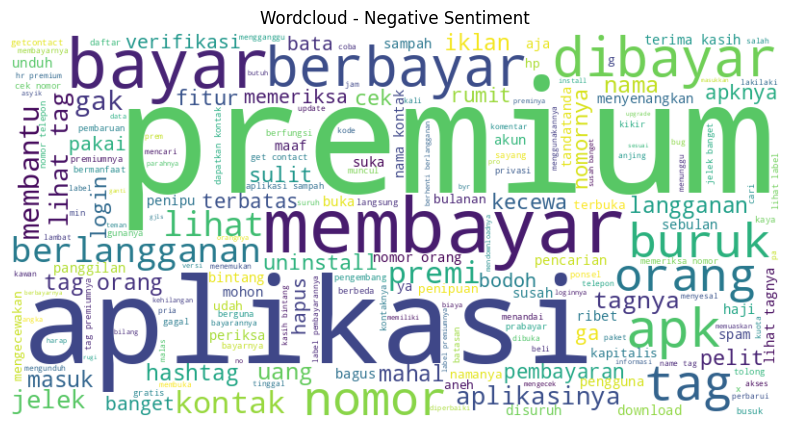

In [65]:
# Membuat Wordcloud untuk kelas negatif dengan stopword removal tambahan
wordcloud_negative = create_wordcloud_with_stopwords(negative_texts, additional_stopwords)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud - Negative Sentiment')
plt.show()

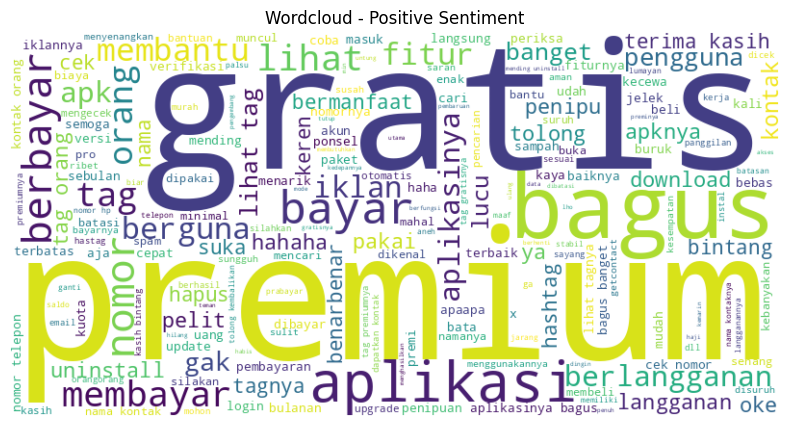

In [66]:
# Membuat Wordcloud untuk kelas positif dengan stopword removal tambahan
wordcloud_positive = create_wordcloud_with_stopwords(positive_texts, additional_stopwords)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud - Positive Sentiment')
plt.show()

<ipython-input-64-bca8696d1c82>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_freq_series.index, y=word_freq_series.values, palette='viridis')


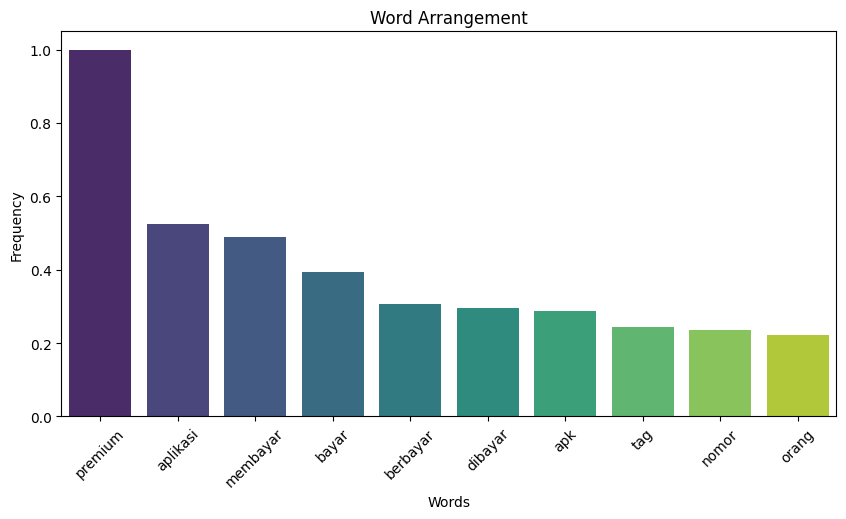

In [67]:
plot_word_arrangement(wordcloud_negative, top_n=10)

<ipython-input-64-bca8696d1c82>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_freq_series.index, y=word_freq_series.values, palette='viridis')


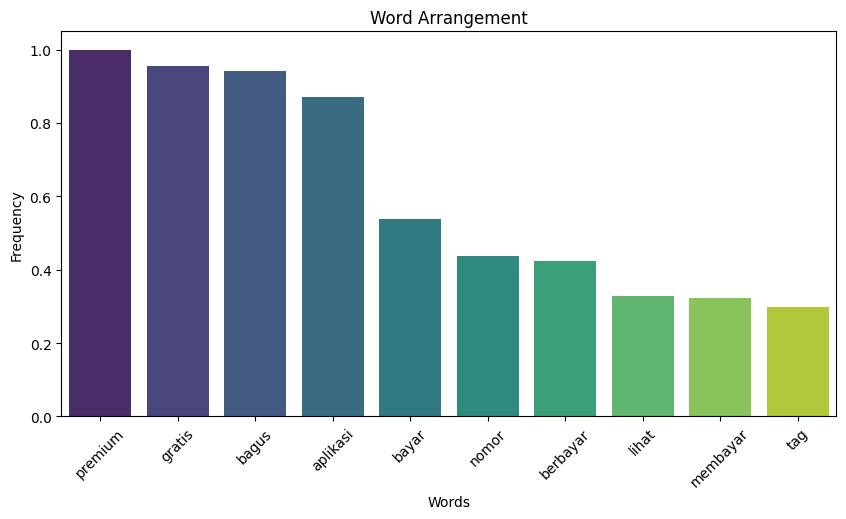

In [68]:
plot_word_arrangement(wordcloud_positive, top_n=10)

In [69]:
from transformers import TFBertForSequenceClassification, BertTokenizer

PRE_TRAINED_MODEL = 'indobenchmark/indobert-base-p2'
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=3)

bert_model.load_weights('/content/drive/MyDrive/Portfolio/Sentiment Analysis User Reviews App GetContact/GetContact3016.h5')
bert_tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
def text_preprocessing(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[-+]?[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.strip()
    return text

def predict_sentiment(text):
    text = text_preprocessing(text)
    encoded_text = bert_tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        padding='max_length',
        truncation='longest_first',
        max_length=60,
        return_attention_mask=True,
        return_token_type_ids=True
    )
    input_ids = np.array([encoded_text['input_ids']])
    token_type_ids = np.array([encoded_text['token_type_ids']])
    attention_mask = np.array([encoded_text['attention_mask']])
    predicted_raw = bert_model.predict({'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask})
    predicted_label = np.argmax(predicted_raw.logits, axis=1)
    sentiment_label = map_label_to_sentiment(predicted_label[0])
    return sentiment_label

In [71]:
def map_label_to_sentiment(label):
    if label == 0:
        return 'Negatif'
    elif label == 1:
        return 'Positif'
    else:
        return None  # Mengabaikan label selain 0 dan 1

In [72]:
# Contoh teks yang ingin diuji
input_text = "aplikasi yang sangat bagus good"

# Lakukan prediksi sentimen pada teks
predicted_sentiment = predict_sentiment(input_text)

# Cetak hasil prediksi
print("Input Text:", input_text)
print("Predicted Sentiment:", predicted_sentiment)

1/1 [==============================] - 4s 4s/step
Input Text: aplikasi yang sangat bagus good
Predicted Sentiment: Positif


In [73]:
# Contoh teks yang ingin diuji
input_text = "Bagus sekali aplikasinya"

# Lakukan prediksi sentimen pada teks
predicted_sentiment = predict_sentiment(input_text)

# Cetak hasil prediksi
print("Input Text:", input_text)
print("Predicted Sentiment:", predicted_sentiment)

1/1 [==============================] - 0s 70ms/step
Input Text: Bagus sekali aplikasinya
Predicted Sentiment: Positif


In [74]:
# Contoh teks yang ingin diuji
input_text = "Aplikasi jelek banget"

# Lakukan prediksi sentimen pada teks
predicted_sentiment = predict_sentiment(input_text)

# Cetak hasil prediksi
print("Input Text:", input_text)
print("Predicted Sentiment:", predicted_sentiment)

1/1 [==============================] - 0s 66ms/step
Input Text: Aplikasi jelek banget
Predicted Sentiment: Negatif
